<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/feature_selection_400n_7hrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bankruptcy Feature Selection: 5-Method Importance Playbook

This notebook computes feature importance **using five complementary methods** to help you pick 5–7 attributes for classification:

1. Random Forest (built-in Gini/MDI)
2. Gradient Boosting (built-in importance)
3. Permutation Feature Importance (model-agnostic)
4. SHAP (TreeExplainer over a tree model)
5. Logistic Regression Coefficients (after scaling)

**Dataset**: `utkarshx27/american-companies-bankruptcy-prediction-dataset` via `kagglehub` (as requested).

Outputs:
- Per-method importance tables
- A combined ranking table (average rank & consensus)
- Simple matplotlib bar charts

> Tip: After you review the final combined ranking, pick your **Top 5–7 features** to train your classification model pipeline.

In [ ]:
# ===== Setup & Installs (Kaggle usually has most of these; safe to re-run) =====
!pip -q install kagglehub shap lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings('ignore')


## Load Dataset via `kagglehub`
The code below follows your given pattern. Update `file_path` to the CSV within the dataset if needed.

**Expected columns** (as provided):
- `company_name` (drop)  
- `status_label` (target)  
- `year` (1999–2018)  
- `X1 … X18` with meanings per your mapping


In [ ]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Set the CSV file path **inside** the dataset (adjust if needed)
# Explore the dataset directory printed below to confirm the file name.
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
file_path = None  # e.g., "american_bankruptcy.csv" if needed


# โหลด dataset จาก Kaggle input path
df = pd.read_csv("/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv")

# แสดงข้อมูล 5 แถวแรก
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


## Basic Preprocessing
- Drop `company_name` (ID-like)
- Keep `year` as numeric (or one-hot encode later if needed)
- Define feature list (exclude `status_label`)
- Impute missing values (median)
- Split into train/test (stratified)


In [ ]:
# Drop obvious non-feature column(s)
df_proc = df.copy()
if 'company_name' in df_proc.columns:
    df_proc = df_proc.drop(columns=['company_name'])

target_col = 'status_label'
assert target_col in df_proc.columns, "status_label (target) not found!"

# Identify feature columns (all except target)
feature_cols = [c for c in df_proc.columns if c != target_col]

# Train/Test Split
X = df_proc[feature_cols]
y = df_proc[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Numeric pipeline: impute median (you can add scaler per-model later)
numeric_features = feature_cols
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder='drop'
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (59011, 19)  Test shape: (19671, 19)


## 1) Random Forest Importance

In [ ]:
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
    ))
])
rf_pipe.fit(X_train, y_train)
rf = rf_pipe.named_steps['rf']

# Extract fitted features order from ColumnTransformer
feat_names = numeric_features
rf_importance = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print(rf_importance.head(10))
rf_importance_df = rf_importance.reset_index()
rf_importance_df.columns = ['feature', 'rf_importance']
rf_importance_df.head()

year    0.076453
X8      0.073366
X6      0.067183
X15     0.061953
X3      0.058252
X17     0.054311
X7      0.052971
X1      0.052669
X11     0.052257
X13     0.050305
dtype: float64


,feature,rf_importance
0,year,0.076453
1,X8,0.073366
2,X6,0.067183
3,X15,0.061953
4,X3,0.058252


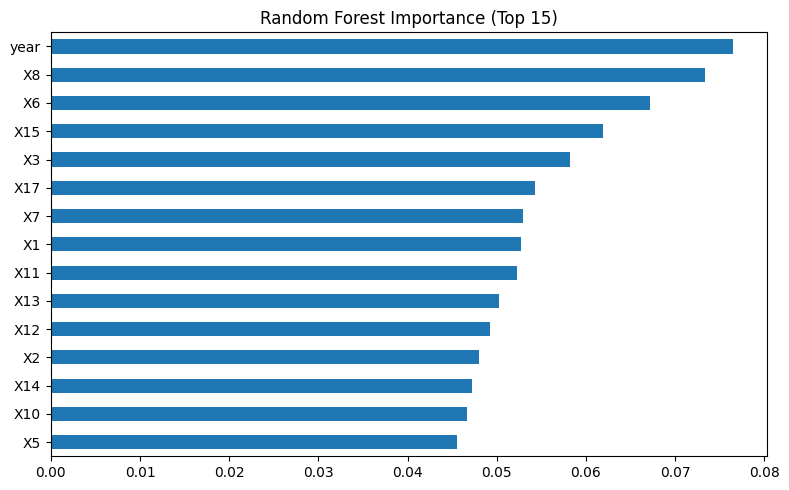

In [ ]:
# Plot RF importances
plt.figure(figsize=(8,5))
rf_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Random Forest Importance (Top 15)')
plt.tight_layout()
plt.show()

## 2) Gradient Boosting Importance (sklearn GBDT)
*(You can switch to XGBoost/LightGBM if preferred — both also expose built-in importance like `gain`.)*

In [ ]:
gb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("gb", GradientBoostingClassifier(random_state=42))
])
gb_pipe.fit(X_train, y_train)
gb = gb_pipe.named_steps['gb']
gb_importance = pd.Series(gb.feature_importances_, index=feat_names).sort_values(ascending=False)
print(gb_importance.head(10))
gb_importance_df = gb_importance.reset_index(); gb_importance_df.columns = ['feature','gb_importance']
gb_importance_df.head()

X8      0.147044
year    0.142131
X6      0.122225
X11     0.084288
X3      0.071333
X17     0.052114
X13     0.051508
X5      0.048150
X18     0.043496
X15     0.040039
dtype: float64


,feature,gb_importance
0,X8,0.147044
1,year,0.142131
2,X6,0.122225
3,X11,0.084288
4,X3,0.071333


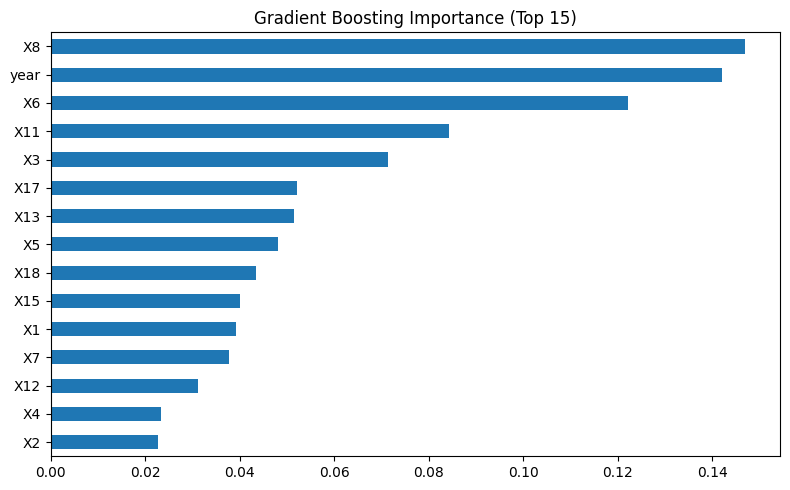

In [ ]:
plt.figure(figsize=(8,5))
gb_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Gradient Boosting Importance (Top 15)')
plt.tight_layout()
plt.show()

## 3) Permutation Feature Importance (model-agnostic on RF model)
Runs on the **validation** set to estimate performance drop when shuffling each feature.

In [ ]:
rf_pipe_score = rf_pipe.score(X_test, y_test)
perm = permutation_importance(rf_pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_scores = pd.Series(perm.importances_mean, index=feat_names).sort_values(ascending=False)
print("Base RF score:", rf_pipe_score)
print(perm_scores.head(10))
perm_df = perm_scores.reset_index(); perm_df.columns = ['feature','perm_importance']
perm_df.head()

Base RF score: 0.936912205785166
X17    0.002740
X3     0.002572
X11    0.002572
X2     0.002466
X13    0.002303
X9     0.002252
X10    0.002216
X6     0.002211
X16    0.002166
X14    0.002161
dtype: float64


,feature,perm_importance
0,X17,0.002740
1,X3,0.002572
2,X11,0.002572
3,X2,0.002466
4,X13,0.002303


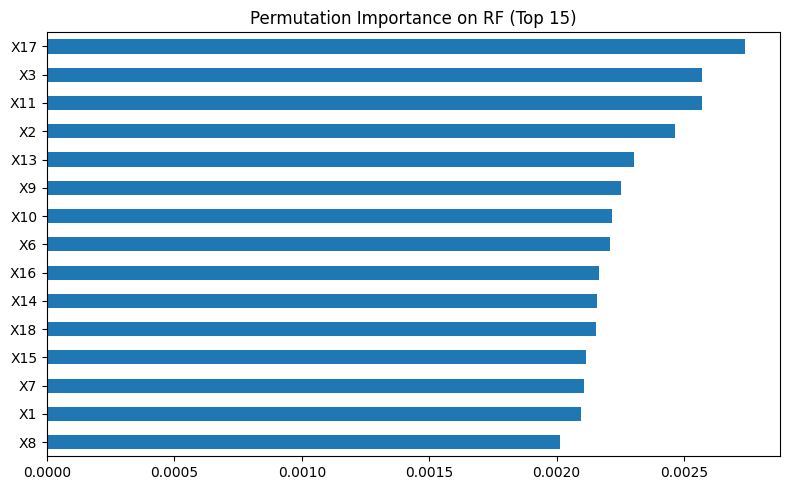

In [ ]:
plt.figure(figsize=(8,5))
perm_scores.head(15).iloc[::-1].plot(kind='barh')
plt.title('Permutation Importance on RF (Top 15)')
plt.tight_layout()
plt.show()

## 4) SHAP (TreeExplainer on RF)
We take **mean absolute SHAP value** per feature on the validation set as global importance.

In [ ]:
# Build a fresh RF (fitted) object on imputed data to pass raw arrays to SHAP
X_train_imp = preprocess.fit_transform(X_train)
X_test_imp = preprocess.transform(X_test)
rf_shap = RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=42, n_jobs=-1)
rf_shap.fit(X_train_imp, y_train)

explainer = shap.TreeExplainer(rf_shap)
shap_values = explainer.shap_values(X_test_imp)
if isinstance(shap_values, list):
    # For binary classification, take class 1 contributions
    sv = shap_values[1]
else:
    sv = shap_values

shap_abs_mean = np.abs(sv).mean(axis=0)
shap_importance = pd.Series(shap_abs_mean, index=feat_names).sort_values(ascending=False)
print(shap_importance.head(10))
shap_df = shap_importance.reset_index(); shap_df.columns = ['feature','shap_importance']
shap_df.head()

year    0.032519
X8      0.031458
X3      0.029251
X6      0.027696
X17     0.027142
X1      0.026350
X15     0.026073
X7      0.025946
X13     0.025909
X10     0.024302
dtype: float64


,feature,shap_importance
0,year,0.032519
1,X8,0.031458
2,X3,0.029251
3,X6,0.027696
4,X17,0.027142


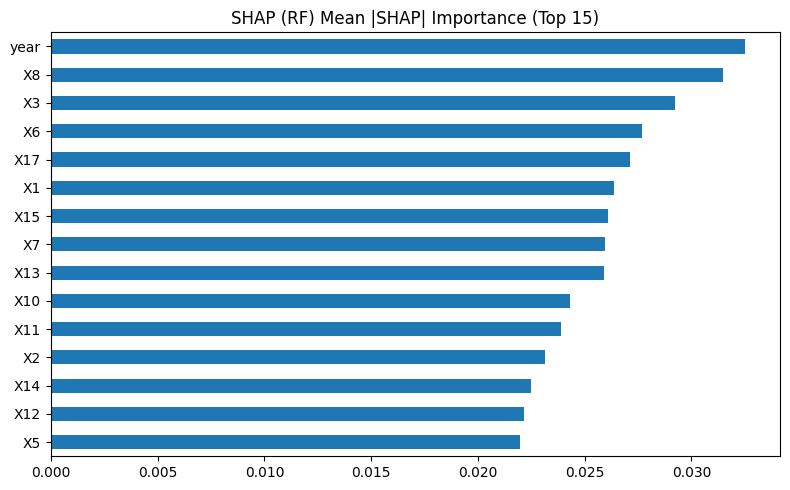

In [ ]:
plt.figure(figsize=(8,5))
shap_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('SHAP (RF) Mean |SHAP| Importance (Top 15)')
plt.tight_layout()
plt.show()

## 5) Logistic Regression Coefficients (after scaling)
We use absolute coefficient magnitude as global importance.
- Pipeline: Impute → Scale → LogisticRegression
- For binary target, take `abs(coef_)`. If OvR, average abs across classes.

In [ ]:
logit_pipe = Pipeline(steps=[
    ("prep", ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features),
    ], remainder='drop')),
    ("logit", LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')),
])
logit_pipe.fit(X_train, y_train)
logit = logit_pipe.named_steps['logit']

coefs = logit.coef_
if coefs.ndim == 1:
    coef_abs = np.abs(coefs)
else:
    coef_abs = np.mean(np.abs(coefs), axis=0)
logit_importance = pd.Series(coef_abs, index=feat_names).sort_values(ascending=False)
print(logit_importance.head(10))
logit_df = logit_importance.reset_index(); logit_df.columns = ['feature','logit_importance']
logit_df.head()

X8      2.649358
X1      1.648422
X17     0.921027
X3      0.825860
X14     0.774304
X12     0.744423
X5      0.520940
year    0.384812
X10     0.354258
X4      0.296635
dtype: float64


,feature,logit_importance
0,X8,2.649358
1,X1,1.648422
2,X17,0.921027
3,X3,0.825860
4,X14,0.774304


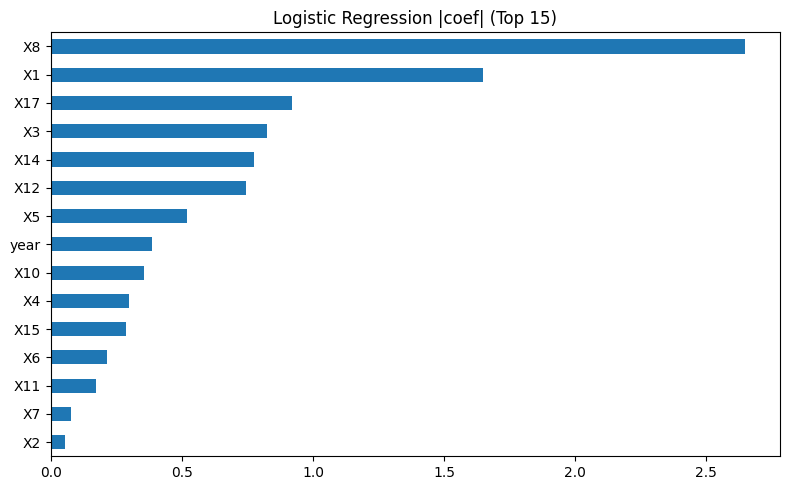

In [ ]:
plt.figure(figsize=(8,5))
logit_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Logistic Regression |coef| (Top 15)')
plt.tight_layout()
plt.show()

## Combine Rankings
We convert each method’s importances into ranks (1 = most important), then compute **average rank** and **consensus count** (how many methods put the feature in Top-k).

In [ ]:
dfs = [rf_importance_df, gb_importance_df, perm_df, shap_df, logit_df]
merged = None
for d in dfs:
    merged = d if merged is None else merged.merge(d, on='feature', how='outer')

# Fill missing with 0 importance (if any)
for c in merged.columns:
    if c != 'feature':
        merged[c] = merged[c].fillna(0.0)

# Create per-method ranks (1=best). Use rank(ascending=False).
rank_cols = []
for c in merged.columns:
    if c != 'feature':
        rname = c + '_rank'
        merged[rname] = merged[c].rank(ascending=False, method='average')
        rank_cols.append(rname)

merged['avg_rank'] = merged[rank_cols].mean(axis=1)
merged_sorted = merged.sort_values('avg_rank', ascending=True)
merged_sorted.head(15)

,feature,rf_importance,gb_importance,perm_importance,shap_importance,logit_importance,rf_importance_rank,gb_importance_rank,perm_importance_rank,shap_importance_rank,logit_importance_rank,avg_rank
11,X3,0.058252,0.071333,0.002572,0.029251,0.825860,5.0,5.0,2.5,3.0,4.0,3.9
8,X17,0.054311,0.052114,0.002740,0.027142,0.921027,6.0,6.0,1.0,5.0,3.0,4.2
16,X8,0.073366,0.147044,0.002013,0.031458,2.649358,2.0,1.0,15.0,2.0,1.0,4.2
14,X6,0.067183,0.122225,0.002211,0.027696,0.213135,3.0,3.0,8.0,4.0,12.0,6.0
18,year,0.076453,0.142131,0.001601,0.032519,0.384812,1.0,2.0,19.0,1.0,8.0,6.2
2,X11,0.052257,0.084288,0.002572,0.023894,0.171895,9.0,4.0,2.5,11.0,13.0,7.9
0,X1,0.052669,0.039254,0.002094,0.026350,1.648422,8.0,11.0,14.0,6.0,2.0,8.2
6,X15,0.061953,0.040039,0.002115,0.026073,0.287473,4.0,10.0,12.0,7.0,11.0,8.8
4,X13,0.050305,0.051508,0.002303,0.025909,0.013247,10.0,7.0,5.0,9.0,19.0,10.0
15,X7,0.052971,0.037675,0.002110,0.025946,0.076219,7.0,12.0,13.0,8.0,14.0,10.8


Top-7 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,perm_importance_rank,shap_importance_rank,logit_importance_rank,avg_rank
11,X3,3.9,5.0,5.0,2.5,3.0,4.0,3.9
8,X17,4.2,6.0,6.0,1.0,5.0,3.0,4.2
16,X8,4.2,2.0,1.0,15.0,2.0,1.0,4.2
14,X6,6.0,3.0,3.0,8.0,4.0,12.0,6.0
18,year,6.2,1.0,2.0,19.0,1.0,8.0,6.2
2,X11,7.9,9.0,4.0,2.5,11.0,13.0,7.9
0,X1,8.2,8.0,11.0,14.0,6.0,2.0,8.2


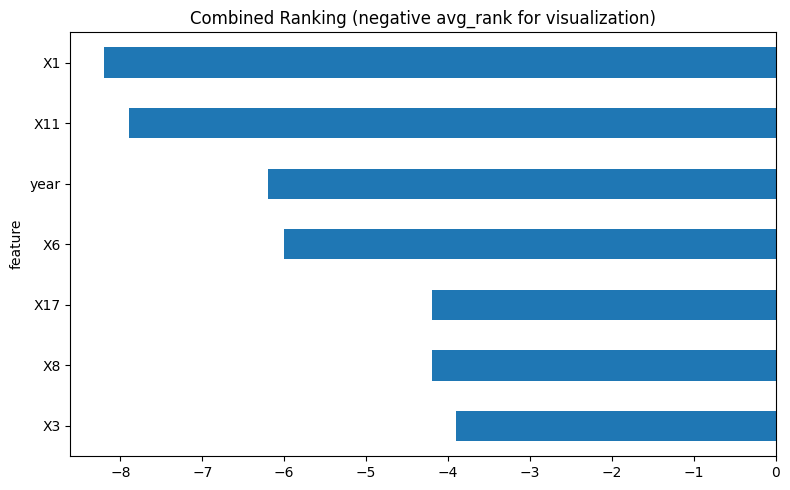

In [ ]:
from math import ceil
TOP_K = 7
topk = merged_sorted.head(TOP_K).copy()
print("Top-{} features by average rank:".format(TOP_K))
display(topk[['feature','avg_rank'] + [c for c in merged.columns if c.endswith('_rank')]])

# Plot combined top-k by (negative avg_rank for bar chart convenience)
plt.figure(figsize=(8,5))
to_plot = topk.set_index('feature')['avg_rank'].sort_values(ascending=False)
( -to_plot ).iloc[::-1].plot(kind='barh')
plt.title('Combined Ranking (negative avg_rank for visualization)')
plt.tight_layout()
plt.show()

In [ ]:
dfs = [perm_df, shap_df, logit_df]
merged = None
for d in dfs:
    merged = d if merged is None else merged.merge(d, on='feature', how='outer')

# Fill missing with 0 importance (if any)
for c in merged.columns:
    if c != 'feature':
        merged[c] = merged[c].fillna(0.0)

# Create per-method ranks (1=best). Use rank(ascending=False).
rank_cols = []
for c in merged.columns:
    if c != 'feature':
        rname = c + '_rank'
        merged[rname] = merged[c].rank(ascending=False, method='average')
        rank_cols.append(rname)

merged['avg_rank'] = merged[rank_cols].mean(axis=1)
merged_sorted = merged.sort_values('avg_rank', ascending=True)
merged_sorted.head(15)

,feature,perm_importance,shap_importance,logit_importance,perm_importance_rank,shap_importance_rank,logit_importance_rank,avg_rank
8,X17,0.002740,0.027142,0.921027,1.0,5.0,3.0,3.000000
11,X3,0.002572,0.029251,0.825860,2.5,3.0,4.0,3.166667
16,X8,0.002013,0.031458,2.649358,15.0,2.0,1.0,6.000000
0,X1,0.002094,0.026350,1.648422,14.0,6.0,2.0,7.333333
14,X6,0.002211,0.027696,0.213135,8.0,4.0,12.0,8.000000
1,X10,0.002216,0.024302,0.354258,7.0,10.0,9.0,8.666667
2,X11,0.002572,0.023894,0.171895,2.5,11.0,13.0,8.833333
5,X14,0.002161,0.022486,0.774304,10.0,13.0,5.0,9.333333
18,year,0.001601,0.032519,0.384812,19.0,1.0,8.0,9.333333
6,X15,0.002115,0.026073,0.287473,12.0,7.0,11.0,10.000000


Top-7 features by average rank:


,feature,avg_rank,perm_importance_rank,shap_importance_rank,logit_importance_rank,avg_rank
8,X17,3.000000,1.0,5.0,3.0,3.000000
11,X3,3.166667,2.5,3.0,4.0,3.166667
16,X8,6.000000,15.0,2.0,1.0,6.000000
0,X1,7.333333,14.0,6.0,2.0,7.333333
14,X6,8.000000,8.0,4.0,12.0,8.000000
1,X10,8.666667,7.0,10.0,9.0,8.666667
2,X11,8.833333,2.5,11.0,13.0,8.833333


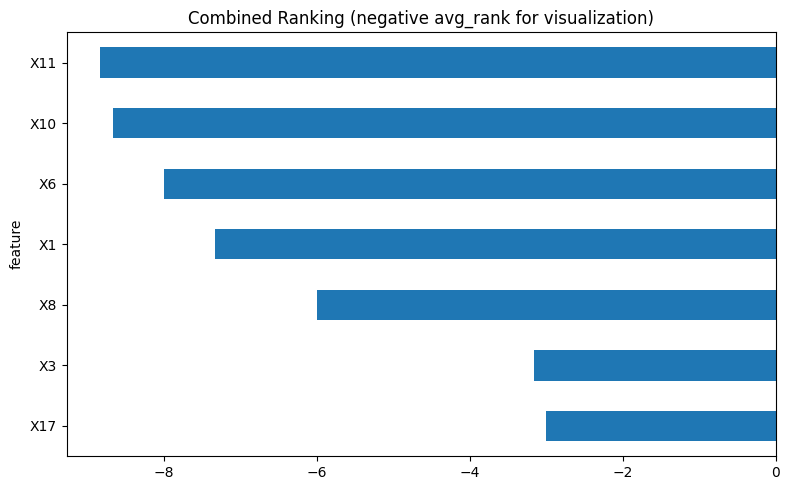

In [ ]:
from math import ceil
TOP_K = 7
topk = merged_sorted.head(TOP_K).copy()
print("Top-{} features by average rank:".format(TOP_K))
display(topk[['feature','avg_rank'] + [c for c in merged.columns if c.endswith('_rank')]])

# Plot combined top-k by (negative avg_rank for bar chart convenience)
plt.figure(figsize=(8,5))
to_plot = topk.set_index('feature')['avg_rank'].sort_values(ascending=False)
( -to_plot ).iloc[::-1].plot(kind='barh')
plt.title('Combined Ranking (negative avg_rank for visualization)')
plt.tight_layout()
plt.show()

### Notes
- You can **swap GradientBoostingClassifier** for **XGBoost/LightGBM** and use their `feature_importances_` or Booster importance types (`gain`, `cover`).
- For **Permutation** and **SHAP**, you can run them on any trained model; here we used RF to keep runtime reasonable.
- After deciding your **Top 5–7 features**, re-train your classification model and report metrics: Accuracy, Precision/Recall, F1, ROC-AUC, Confusion Matrix, etc.